In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import thermal_property_calculator as tpc
import scipy.special as sp
from scipy.optimize import  fsolve
import scipy.integrate as integrate
import seaborn as sns
import matplotlib.colors as pltc
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [28]:
def strain(r, z, A, a, alpha=3.2, beta=3.2):
    fac = sp.jv(0,alpha)/sp.iv(0, beta)
    dwdr = A*(-alpha/a*sp.jv(1, alpha*r/a) - fac*beta/a*sp.iv(1, beta*r/a))
    d2wdr2 = A*(-(alpha/a)**2*(sp.jv(0,alpha*r/a) - alpha*r/(a)*sp.jv(1, alpha*r/a)) -
                fac*(beta/a)**2*(sp.iv(0,alpha*r/a) + alpha*r/(a)*sp.iv(1, alpha*r/a)))
    er = -z*d2wdr2
    et = -z/r*dwdr
    return er + et

In [29]:
def mode_shape(r, A, a, alpha=3.2, beta=3.2):
    fac = sp.jv(0,alpha)/sp.iv(0, beta)
    w = A*(sp.jv(0, alpha*r/a) - fac*sp.iv(0, beta*r/a))
    return w
def mem_mode_shape(r,A,a):
    w = A*sp.jv(0,sp.jn_zeros(0,1)*r/a)
    return w

In [30]:
N_cel = 200
A = 1*10**-9
a = 5*10**-6
h = 45*10**-9
r = np.linspace(-a, a, N_cel)
r_mat = np.stack([r for _ in range(N_cel)], axis=0)
z = np.linspace(-h/2,h/2,N_cel)
z_mat = np.stack([z for _ in range(N_cel)], axis=1)

strain_fl = strain(r_mat, z_mat, A, a)

In [31]:
r = np.linspace(-a, a, N_cel)
z = np.array([h/2 for i in range(N_cel)])

strain_line = strain(r, z, A, a)
mode_shape_line = mode_shape(r,A,a)
modeshape_mem = mem_mode_shape(r,A,a)

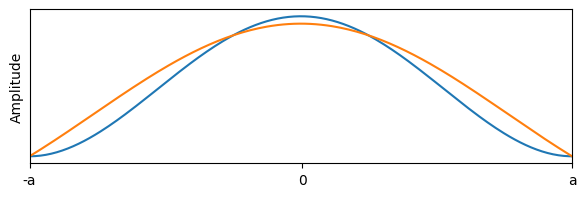

In [32]:
fig, ax = plt.subplots(1,1, figsize=(7,2))
ax.plot(mode_shape_line)
ax.plot(modeshape_mem)
#ax.set_ylim(-2.3*10**-5,2.3*10**-5)
x_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
x_tick_labels = ['-a','0','a']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
ax.set_yticks([])
ax.set_ylabel('Amplitude')
ax.set_xlim(0,N_cel-1)
plt.savefig(r'figures/plate_amplitude.pdf', bbox_inches='tight')
plt.show()

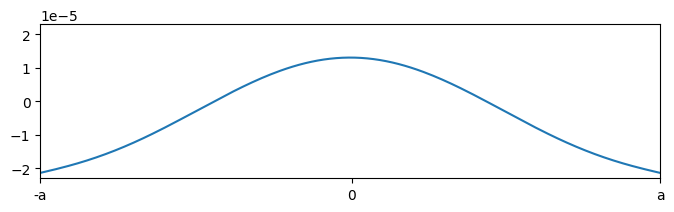

In [33]:
fig, ax = plt.subplots(1,1, figsize=(8,2))
ax.plot(strain_line)
ax.set_ylim(-2.3*10**-5,2.3*10**-5)
x_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
x_tick_labels = ['-a','0','a']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
ax.set_xlim(0,N_cel-1)
plt.show()

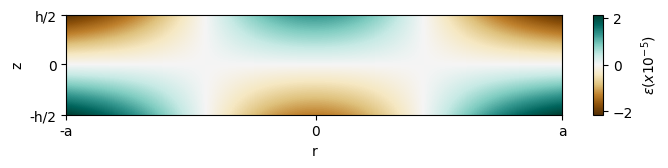

In [34]:
fig, ax = plt.subplots(1,1, figsize=(8,1.3))
mapita = ax.imshow(strain_fl*10**5, aspect='auto',cmap='BrBG',norm='linear')
fig.colorbar(mapita, label='$\epsilon (x10^{-5})$',aspect=10)
x_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
x_tick_labels = ['-a','0','a']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
y_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
y_tick_labels = ['-h/2','0','h/2']
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels)
ax.set_xlim(0,N_cel-1)
ax.set_ylim(0,N_cel-1)
ax.set_ylabel('z')
ax.set_xlabel('r')
plt.savefig(r'figures/plate_strain.pdf', bbox_inches='tight')
plt.show()

In [35]:
def theta_z(r, z, A, a, h, omega, c_v, kappa, rho, nu, E, alpha_T, T, alpha=3.2, beta=3.2):
    lamb = np.sqrt(1j*omega*rho*c_v/kappa)

    fac = sp.jv(0,alpha)/sp.iv(0, beta)
    dwdr = A*(-alpha/a*sp.jv(1, alpha*r/a) - fac*beta/a*sp.iv(1, beta*r/a))
    d2wdr2 = A*(-(alpha/a)**2*(sp.jv(0,alpha*r/a)-alpha*r/a*sp.jv(1, alpha*r/a)) - fac*(beta/a)**2*(sp.iv(0,alpha*r/a)+alpha*r/(a)*sp.iv(1, alpha*r/a)))
    lap2w = d2wdr2 + 1/r*dwdr

    q = -1j*omega*E*alpha_T*T*lap2w/(kappa*(1-2*nu))

    theta = q/lamb**2*(np.sinh(lamb*z)/(lamb*np.cosh(lamb*h/2)) - z)

    return np.real(theta)

In [36]:
N_cel = 200
A = 1*10**-9
a = 5*10**-6
h = 45*10**-9
omega = 10*10**6
c_v = 500
kappa = 1
rho = 3375
nu = 0.301
E = 103*10**9
alpha_T = 10**-5
T = 200
r = np.linspace(-a, a, N_cel)
r_mat = np.stack([r for _ in range(N_cel)], axis=0)
z = np.linspace(-h/2,h/2,N_cel)
z_mat = np.stack([z for _ in range(N_cel)], axis=1)

temp_z = theta_z(r_mat, z_mat, A, a, h, omega, c_v, kappa, rho, nu, E, alpha_T, T)

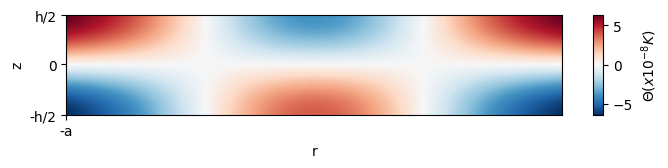

In [37]:
fig, ax = plt.subplots(1,1, figsize=(8,1.3))
mapita = ax.imshow(temp_z*10**8, aspect='auto',cmap='RdBu_r',norm='linear')
fig.colorbar(mapita, label='$\Theta (x10^{-8} K)$',aspect=10)
x_ticks = [0,N_cel,N_cel]  # Define the tick positions
x_tick_labels = ['-a','0','a']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
y_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
y_tick_labels = ['-h/2','0','h/2']
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels)
ax.set_xlim(0,N_cel-1)
ax.set_ylim(0,N_cel-1)
ax.set_ylabel('z')
ax.set_xlabel('r')
plt.savefig(r'figures/plate_ZModel_temperature.pdf', bbox_inches='tight')
plt.show()

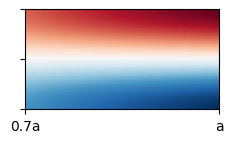

In [38]:
fig, ax = plt.subplots(1,1, figsize=(2.5,1.3))
mapita = ax.imshow(temp_z, aspect='auto',cmap='RdBu_r',norm='linear')
x_ticks = [0,N_cel*0.85,N_cel-1]  # Define the tick positions
x_tick_labels = ['-a','0.7a','a']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
y_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
y_tick_labels = ['','','']
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels)
ax.set_xlim(0.85*N_cel,N_cel-1)
ax.set_ylim(0,N_cel-1)
plt.savefig(r'figures_plate_ZoomZModel_temperature.pdf', bbox_inches='tight')
plt.show()

In [39]:
def theta_rz(r, z, A, a, h, omega, c_v, kappa, rho, nu, E, alpha_T, T, N_sum, alpha=3.2, beta=3.2):
    theta = np.zeros_like(r)
    x0ns = sp.jn_zeros(0, N_sum)
    terms = []
    for n in range(1,N_sum):
        x0n = x0ns[n-1]
        bn = np.sqrt((x0n/a)**2 + 1j*omega*rho*c_v/kappa)
        int_lap = A*(alpha**2 + beta**2)*x0n**3*sp.jv(0,alpha)*sp.jv(1,x0n)/((alpha**2-x0n**2)*(beta**2+x0n**2))
        cn = -1j*omega*E*alpha_T*T*2*int_lap/(kappa*(1-2*nu)*a**2*sp.jv(1,x0n)**2)

        term_n = sp.jv(0,x0n*r/a)*(cn/bn**2)*(np.sinh(bn*z)/(bn*np.cosh(bn*h/2))-z)
        theta = theta + term_n
        if  n < 7:
            terms.append(np.real(term_n))
    return np.real(theta), terms

In [40]:
N_cel = 200
A = 1*10**-9
a = 5*10**-6
h = 45*10**-9
omega = 10*10**6
c_v = 500
kappa = 1
rho = 3375
nu = 0.301
E = 103*10**9
alpha_T = 10**-5
T = 200
r = np.linspace(-a, a, N_cel)
r_mat = np.stack([r for _ in range(N_cel)], axis=0)
z = np.linspace(-h/2,h/2,N_cel)
z_mat = np.stack([z for _ in range(N_cel)], axis=1)

temp_rz, terms = theta_rz(r_mat, z_mat, A, a, h, omega, c_v, kappa, rho, nu, E, alpha_T, T, 200)

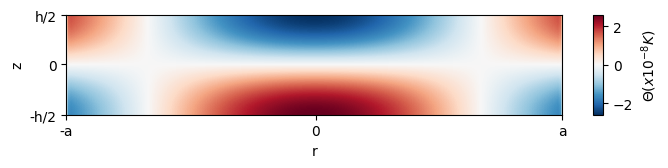

In [41]:
fig, ax = plt.subplots(1,1, figsize=(8,1.3))
mapita = ax.imshow(temp_rz*10**8, aspect='auto',cmap='RdBu_r',norm='linear')
fig.colorbar(mapita, label='$\Theta (x10^{-8} K)$',aspect=10)
x_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
x_tick_labels = ['-a','0','a']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
y_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
y_tick_labels = ['-h/2','0','h/2']
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels)
ax.set_xlim(0,N_cel-1)
ax.set_ylim(0,N_cel-1)
ax.set_ylabel('z')
ax.set_xlabel('r')
plt.savefig(r'figures/plate_RZModel_temperature.pdf', bbox_inches='tight')
plt.show()

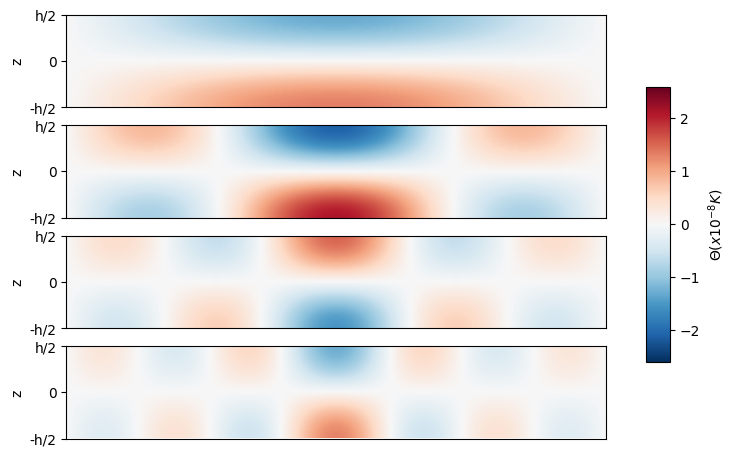

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8,5.5))
x_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
x_tick_labels = ['-a','0','a']
y_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
y_tick_labels = ['-h/2','0','h/2']

gs = GridSpec(4, 1, wspace=0.1)

for i in range(4):
    axs = fig.add_subplot(gs[i,0])
    mapita = axs.imshow(terms[i]*10**8, aspect='auto',cmap='RdBu_r',norm='linear', vmin=-2.6,vmax=2.6)
    #fig.colorbar(mapita, label='$\Theta$',aspect=10)

    axs.set_yticks(y_ticks)
    axs.set_yticklabels(y_tick_labels)
    axs.set_xlim(0,N_cel-1)
    axs.set_ylim(0,N_cel-1)
    axs.set_ylabel('z')
    axs.set_xticks([])
    if i==5:
        axs.set_xlabel('r')
        axs.set_xticks(x_ticks)
        axs.set_xticklabels(x_tick_labels)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
fig.colorbar(mapita, cax=cbar_ax, aspect=5, label='$\Theta (x10^{-8} K)$')

plt.subplots_adjust(wspace=0)
plt.savefig(r'figures/plate_RZModel_temperature_terms.pdf', bbox_inches='tight')
plt.show()

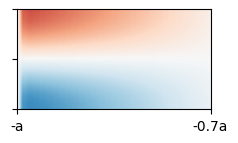

In [43]:
fig, ax = plt.subplots(1,1, figsize=(2.5,1.3))
mapita = ax.imshow(temp_rz*10**8, aspect='auto',cmap='RdBu_r',norm='linear')
#fig.colorbar(mapita, label='$\Theta$',aspect=10)
x_ticks = [0,N_cel*0.15,N_cel/2,N_cel-1]  # Define the tick positions
x_tick_labels = ['-a','-0.7a','0','a']
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
y_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
y_tick_labels = ['','','']
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels)
ax.set_xlim(0,N_cel*0.15)
ax.set_ylim(0,N_cel-1)
plt.savefig(r'figures/plate_ZoomRZModel_temperature.pdf', bbox_inches='tight')
plt.show()

In [44]:
def theta_rz_anis(r, z, A, a, h, omega, c_v, kappa_z, kappa_r, rho, nu, E, alpha_T, T, N_sum, alpha=3.2, beta=3.2):
    theta = np.zeros_like(r)
    x0ns = sp.jn_zeros(0, N_sum)
    terms = []
    for n in range(1,N_sum):
        x0n = x0ns[n-1]
        bn = np.sqrt(kappa_r/kappa_z*(x0n/a)**2 + 1j*omega*rho*c_v/kappa_z)
        int_lap = A*(alpha**2 + beta**2)*x0n**3*sp.jv(0,alpha)*sp.jv(1,x0n)/((alpha**2-x0n**2)*(beta**2+x0n**2))
        cn = -1j*omega*E*alpha_T*T*2*int_lap/(kappa_z*(1-2*nu)*a**2*sp.jv(1,x0n)**2)

        term_n = sp.jv(0,x0n*r/a)*(cn/bn**2)*(np.sinh(bn*z)/(bn*np.cosh(bn*h/2))-z)
        theta = theta + term_n
        if  n < 7:
            terms.append(np.real(term_n))
    return np.real(theta), terms

In [45]:
kappa_z = [0.0001, 0.01, 1]
kappa_r = 1

temp_rz_anis_vec = []
for kappa_zt in kappa_z: 
    temp_rz_anis, _ = theta_rz_anis(r_mat, z_mat, A, a, h, omega, c_v, kappa_zt, kappa_r, rho, nu, E, alpha_T, T, 200)
    temp_rz_anis_vec.append(temp_rz_anis)

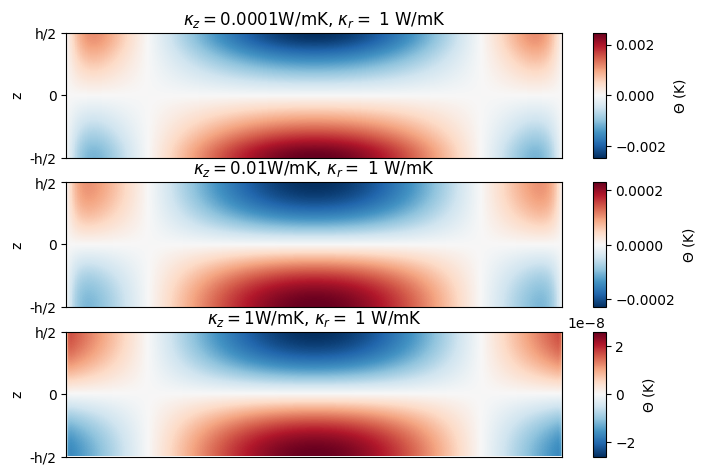

In [46]:
fig = plt.figure(figsize=(8,5.5))
x_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
x_tick_labels = ['-a','0','a']
y_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
y_tick_labels = ['-h/2','0','h/2']

gs = GridSpec(3, 1, wspace=0.1)

for i in range(3):
    axs = fig.add_subplot(gs[i,0])
    mapita = axs.imshow(temp_rz_anis_vec[i], aspect='auto',cmap='RdBu_r',norm='linear')#, vmin=-2.6,vmax=2.6)
    fig.colorbar(mapita, label='$\Theta $ (K)',aspect=10)
    axs.set_title('$\kappa_z=$'+ str(kappa_z[i])+ 'W/mK, $\kappa_r=$ 1 W/mK')
    axs.set_yticks(y_ticks)
    axs.set_yticklabels(y_tick_labels)
    axs.set_xlim(0,N_cel-1)
    axs.set_ylim(0,N_cel-1)
    axs.set_ylabel('z')
    axs.set_xticks([])
    if i==5:
        axs.set_xlabel('r')
        axs.set_xticks(x_ticks)
        axs.set_xticklabels(x_tick_labels)

plt.subplots_adjust(wspace=0)
plt.savefig(r'figures/plate_RZModel_anis.pdf', bbox_inches='tight')
plt.show()

In [54]:
kappa_z = 1
kappa_r = [1, 30, 100]

temp_rz_anis_vec = []
for kappa_rt in kappa_r: 
    temp_rz_anis, _ = theta_rz_anis(r_mat, z_mat, A, a, h, omega, c_v, kappa_z, kappa_rt, rho, nu, E, alpha_T, T, 200)
    temp_rz_anis_vec.append(temp_rz_anis)

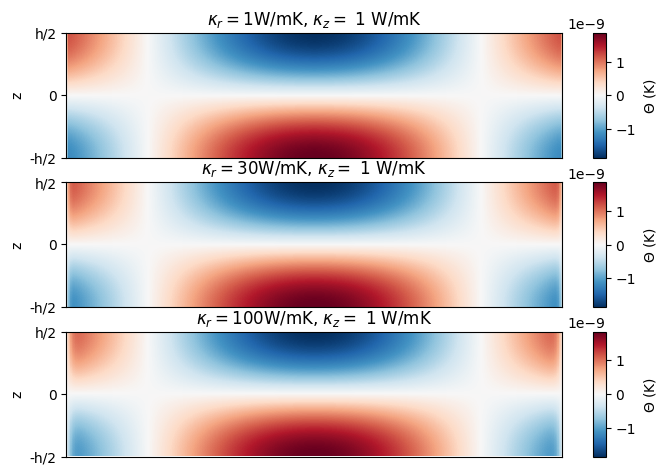

In [55]:
fig = plt.figure(figsize=(8,5.5))
x_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
x_tick_labels = ['-a','0','a']
y_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
y_tick_labels = ['-h/2','0','h/2']

gs = GridSpec(3, 1, wspace=0.1)

for i in range(3):
    axs = fig.add_subplot(gs[i,0])
    mapita = axs.imshow(temp_rz_anis_vec[i], aspect='auto',cmap='RdBu_r',norm='linear')#, vmin=-2.6,vmax=2.6)
    fig.colorbar(mapita, label='$\Theta $ (K)',aspect=10)
    axs.set_title('$\kappa_r=$'+ str(kappa_r[i])+ 'W/mK, $\kappa_z=$ 1 W/mK')
    axs.set_yticks(y_ticks)
    axs.set_yticklabels(y_tick_labels)
    axs.set_xlim(0,N_cel-1)
    axs.set_ylim(0,N_cel-1)
    axs.set_ylabel('z')
    axs.set_xticks([])
    if i==5:
        axs.set_xlabel('r')
        axs.set_xticks(x_ticks)
        axs.set_xticklabels(x_tick_labels)

plt.subplots_adjust(wspace=0)
plt.savefig(r'figures/plate_RZModel_anis.pdf', bbox_inches='tight')
plt.show()

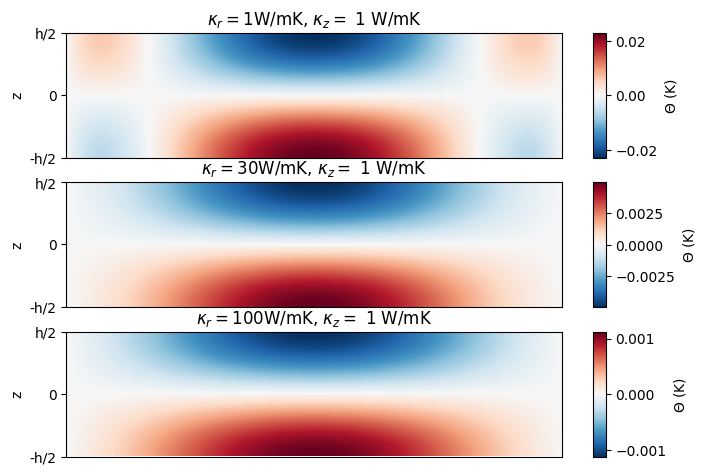

In [51]:
N_cel = 200
A = 1*10**-9
a = 2.5*10**-6
h = 5.65486678e-07
r = np.linspace(-a, a, N_cel)
r_mat = np.stack([r for _ in range(N_cel)], axis=0)
z = np.linspace(-h/2,h/2,N_cel)
z_mat = np.stack([z for _ in range(N_cel)], axis=1)

kappa_z = 1
kappa_r = [1, 30, 100]

temp_rz_anis_vec = []
for kappa_rt in kappa_r: 
    temp_rz_anis, _ = theta_rz_anis(r_mat, z_mat, A, a, h, omega, c_v, kappa_z, kappa_rt, rho, nu, E, alpha_T, T,100)
    temp_rz_anis_vec.append(temp_rz_anis)


fig = plt.figure(figsize=(8,5.5))
x_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
x_tick_labels = ['-a','0','a']
y_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
y_tick_labels = ['-h/2','0','h/2']

gs = GridSpec(3, 1, wspace=0.1)

for i in range(3):
    axs = fig.add_subplot(gs[i,0])
    mapita = axs.imshow(temp_rz_anis_vec[i], aspect='auto',cmap='RdBu_r',norm='linear')#, vmin=-2.6,vmax=2.6)
    fig.colorbar(mapita, label='$\Theta $ (K)',aspect=10)
    axs.set_title('$\kappa_r=$'+ str(kappa_r[i])+ 'W/mK, $\kappa_z=$ 1 W/mK')
    axs.set_yticks(y_ticks)
    axs.set_yticklabels(y_tick_labels)
    axs.set_xlim(0,N_cel-1)
    axs.set_ylim(0,N_cel-1)
    axs.set_ylabel('z')
    axs.set_xticks([])
    if i==5:
        axs.set_xlabel('r')
        axs.set_xticks(x_ticks)
        axs.set_xticklabels(x_tick_labels)

plt.subplots_adjust(wspace=0)
#plt.savefig(r'figures/plate_RZModel_anis.pdf', bbox_inches='tight')
plt.show()

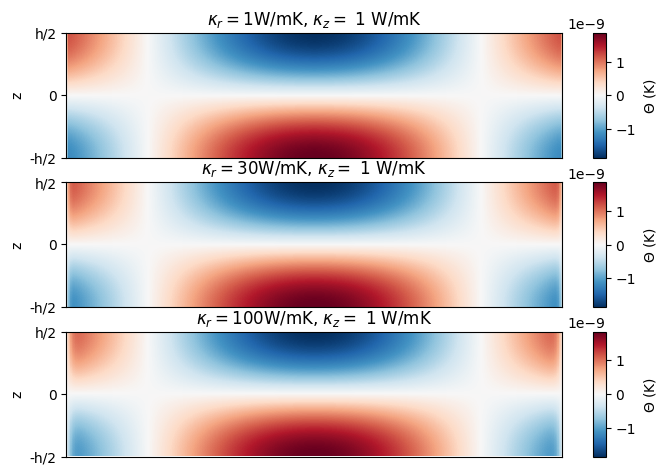

In [53]:
N_cel = 200
A = 1*10**-9
a = 10*10**-6
h = 35e-09
r = np.linspace(-a, a, N_cel)
r_mat = np.stack([r for _ in range(N_cel)], axis=0)
z = np.linspace(-h/2,h/2,N_cel)
z_mat = np.stack([z for _ in range(N_cel)], axis=1)

kappa_z = 1
kappa_r = [1, 30, 100]

temp_rz_anis_vec = []
for kappa_rt in kappa_r: 
    temp_rz_anis, _ = theta_rz_anis(r_mat, z_mat, A, a, h, omega, c_v, kappa_z, kappa_rt, rho, nu, E, alpha_T, T,200)
    temp_rz_anis_vec.append(temp_rz_anis)


fig = plt.figure(figsize=(8,5.5))
x_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
x_tick_labels = ['-a','0','a']
y_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
y_tick_labels = ['-h/2','0','h/2']

gs = GridSpec(3, 1, wspace=0.1)

for i in range(3):
    axs = fig.add_subplot(gs[i,0])
    mapita = axs.imshow(temp_rz_anis_vec[i], aspect='auto',cmap='RdBu_r',norm='linear')#, vmin=-2.6,vmax=2.6)
    fig.colorbar(mapita, label='$\Theta $ (K)',aspect=10)
    axs.set_title('$\kappa_r=$'+ str(kappa_r[i])+ 'W/mK, $\kappa_z=$ 1 W/mK')
    axs.set_yticks(y_ticks)
    axs.set_yticklabels(y_tick_labels)
    axs.set_xlim(0,N_cel-1)
    axs.set_ylim(0,N_cel-1)
    axs.set_ylabel('z')
    axs.set_xticks([])
    if i==5:
        axs.set_xlabel('r')
        axs.set_xticks(x_ticks)
        axs.set_xticklabels(x_tick_labels)

plt.subplots_adjust(wspace=0)
#plt.savefig(r'figures/plate_RZModel_anis.pdf', bbox_inches='tight')
plt.show()

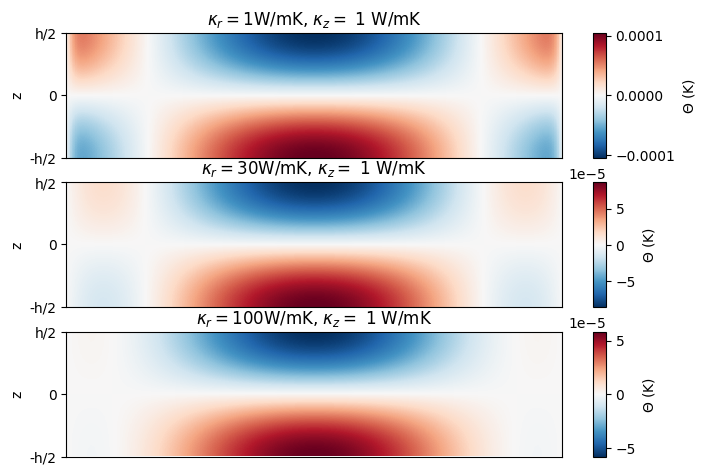

In [56]:
N_cel = 200
A = 1*10**-9
a = 4*10**-6
h = 217e-09
r = np.linspace(-a, a, N_cel)
r_mat = np.stack([r for _ in range(N_cel)], axis=0)
z = np.linspace(-h/2,h/2,N_cel)
z_mat = np.stack([z for _ in range(N_cel)], axis=1)

kappa_z = 1
kappa_r = [1, 30, 100]

temp_rz_anis_vec = []
for kappa_rt in kappa_r: 
    temp_rz_anis, _ = theta_rz_anis(r_mat, z_mat, A, a, h, omega, c_v, kappa_z, kappa_rt, rho, nu, E, alpha_T, T,200)
    temp_rz_anis_vec.append(temp_rz_anis)


fig = plt.figure(figsize=(8,5.5))
x_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
x_tick_labels = ['-a','0','a']
y_ticks = [0,N_cel/2,N_cel-1]  # Define the tick positions
y_tick_labels = ['-h/2','0','h/2']

gs = GridSpec(3, 1, wspace=0.1)

for i in range(3):
    axs = fig.add_subplot(gs[i,0])
    mapita = axs.imshow(temp_rz_anis_vec[i], aspect='auto',cmap='RdBu_r',norm='linear')#, vmin=-2.6,vmax=2.6)
    fig.colorbar(mapita, label='$\Theta $ (K)',aspect=10)
    axs.set_title('$\kappa_r=$'+ str(kappa_r[i])+ 'W/mK, $\kappa_z=$ 1 W/mK')
    axs.set_yticks(y_ticks)
    axs.set_yticklabels(y_tick_labels)
    axs.set_xlim(0,N_cel-1)
    axs.set_ylim(0,N_cel-1)
    axs.set_ylabel('z')
    axs.set_xticks([])
    if i==5:
        axs.set_xlabel('r')
        axs.set_xticks(x_ticks)
        axs.set_xticklabels(x_tick_labels)

plt.subplots_adjust(wspace=0)
#plt.savefig(r'figures/plate_RZModel_anis.pdf', bbox_inches='tight')
plt.show()